In [63]:
import pandas as pd
import talib
import hvplot.pandas 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np


In [64]:
#Acessing CSV information and creating close dataframes 

# Reading CSVs
df_btc = pd.read_csv('olhcv/2yr_btc.csv')
df_eth = pd.read_csv('olhcv/2yr_eth.csv')

# Volume 
btc_vol = df_btc["volume"]
eth_vol = df_eth["volume"]

# Closes
btc_close = df_btc["close"]
eth_close = df_eth["close"]



In [65]:
# Define two testing coins to be used below

# Closes
coin_1 = btc_close
coin_2 = eth_close

# Volume 
coin_1_vol = btc_vol
coin_2_vol = eth_vol


# Volume sma 
coin_1_vol_sma = coin_1_vol.rolling(20).mean()
coin_2_vol_sma = coin_2_vol.rolling(20).mean()


In [66]:
# Overall percent change oscilator score for entire DF
def cor(ws, coin_1, coin_2): 
    
    
    # coin 1
    
    c = []
    for i in range(len(coin_1[100:])-200):
        c.append(coin_1[i+200] - coin_1[i+100])

    h = coin_1.rolling(window = ws).max()
    l = coin_1.rolling(window = ws).min()

    range_1 = h - l
    p = (c /range_1[0:len(coin_1)-300])*100

    
    # coin 2

    ce = []
    for i in range(len(coin_2[100:])-200):
        ce.append(coin_2[i+200] - coin_2[i+100])


    he = coin_2.rolling(window = ws).max()
    le = coin_2.rolling(window = ws).min()

    range_1e = he - le
    pe = (ce /range_1e[0:len(coin_2)-300])*100

    X = np.array(p[ws:])
    y = np.array(pe[ws:])

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

    clf = LinearRegression()


    X_train =X_train.reshape(-1, 1)
    y_train =y_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    clf.fit(X_train, y_train)

    clf.predict(X_test)

    clf.score(X_test, y_test)

    return clf.score(X_test, y_test)

cor(100, coin_1, coin_2)

0.5820088823874823

In [67]:
# Over all: close correlation score of closes in DF
def close_cor(coin_1, coin_2):   
    X = np.array(coin_1)
    y = np.array(coin_2)

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

    clf = LinearRegression()


    X_train = X_train.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    clf.fit(X_train, y_train)

    clf.predict(X_test)

    clf.score(X_test, y_test)
    
    return clf.score(X_test, y_test)

close_cor(coin_1, coin_2)

0.8185372820840079

In [68]:
# Create percent change oscilator as variable 

# Window Size
ws = 100

# Coin 1 
c = []
for i in range(len(coin_1)-ws):
    c.append(coin_1[i+ws] - coin_1[i])


h = coin_1.rolling(window = ws).max()
l = coin_1.rolling(window = ws).min()

range_1 = h - l
p = (c /range_1[0:len(c)])*100

# Coin 2

ce = []
for i in range(len(coin_2)-ws):
    ce.append(coin_2[i+ws] - coin_2[i])


he = coin_2.rolling(window = ws).max()
le = coin_2.rolling(window = ws).min()

range_1e = he - le
pe = (ce /range_1e[0:len(ce)])*100

In [69]:
# Correlation function to be used in backtesting

def cor(look_ahead):

    X = np.array(p[look_ahead - 100: look_ahead])
    y = np.array(pe[look_ahead - 100 : look_ahead])

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4)

    clf = LinearRegression()


    X_train = X_train.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    clf.fit(X_train, y_train)

    clf.predict(X_test)

    clf.score(X_test, y_test)
    
    return clf.score(X_test, y_test)

    

In [70]:
# Backtesting variables

# MACD calculation, using standard inputs 
fast_ema_value = 12 
slow_ema_value = 26
signal_smoothing = 9

#EMA for MACD
ema_12 = talib.EMA(coin_2, fast_ema_value)
ema_26 = talib.EMA(coin_2, slow_ema_value)


# MACD
macd = ema_12 - ema_26

# Signal
signal_9 = talib.EMA(macd, signal_smoothing)

# Histogram
hist = macd - signal_9

# USD usage per trade 

USD = 100000 

In [71]:
# Backtesting long trades
def long_backtest():

    # Defining variables for backtesting

    start = 200
    la = start + 1

    # Capturing entries and exits
    entry = []
    exit = []

    p_spread_long = []

    index_count = 0

    in_trade = 0

    # Iterating through coin df to track trades
    for i in range(len(coin_2[start:])-start):


        if macd[i+start] > signal_9[i+start] and macd[i+la] < signal_9[i+la] and macd[i+la] < 0  and cor(i + start) < 0.7 and coin_2_vol_sma[i +start] < coin_2_vol[i +start] and p[i + start] < pe[i + start]: 
                if in_trade == 0:

                    entry.append(coin_2[i+start])
                    in_trade = 1

        if macd[i+start] < signal_9[i+start] and macd[i+la] > signal_9[i+la] and macd[i+la] > 0:

                if in_trade == 1:

                    exit.append(coin_2[i+la])
                    in_trade = 0


    # Calculate long profit as a percentage               

    perc_delta =[]
    for i in range(len(entry)-1):

        perc_delta.append((exit[i] - entry[i])/entry[i])

    df_profit_long = pd.DataFrame(perc_delta)*USD
    
    return df_profit_long


In [72]:
# Backtesting short trades
def short_backtest():

    # Capturing entries and exits
    entrys = []
    exits = []

    p_spread_long = []

    index_count = 0

    start = 200
    la = start + 1

    in_trade = 0

    # Iterating through coin close dataframe to track trades

    for i in range(len(coin_2[start:])-start):

        if macd[i+start] > signal_9[i+start] and macd[i+la] < signal_9[i+la] and macd[i+la] > 5  and cor(i + start) > 0.5 and coin_2_vol_sma[i +start] > coin_2_vol[i +start] and p[i + start] > pe[i + start]:
                if in_trade == 0:

                    entrys.append(coin_2[i+la])
                    in_trade = 1

        if macd[i+start] > signal_9[i+start] and macd[i+la] < signal_9[i+la] and macd[i+la] < 0 :

                if in_trade == 1:

                    exits.append(coin_2[i+la])
                    in_trade = 0


    # Calculate short profit                 

    perc_delta_shorts_list =[]
    for i in range(len(entrys)-1):

        perc_delta_shorts_list.append((exits[i] - entrys[i])/entrys[i])


    df_profits_short = pd.DataFrame(perc_delta_shorts_list)*-USD
    
    return df_profits_short

In [73]:
# Saving backtesting function as variable 

longs = long_backtest()
shorts = short_backtest()


In [74]:
# Correcting issues in dataframe lengths in order to add them together

if len(shorts) > len(longs): 

    Dif = len(shorts) - len(longs)

    added = []
    for i in range(Dif+1):

        added.append(0)


    added_df = pd.DataFrame(added)

    fixed_longs = longs.append(added_df, ignore_index=True)

    total_profit = (shorts + fixed_longs).dropna()

elif len(longs) > len(shorts):
    
    Dif = len(longs) - len(shorts)

    added = []
    for i in range(Dif+1):

        added.append(0)


    added_df = pd.DataFrame(added)

    fixed_shorts = shorts.append(added_df, ignore_index=True)

    total_profit = (longs + fixed_shorts).dropna()

<AxesSubplot:title={'center':'PNL Longs'}>

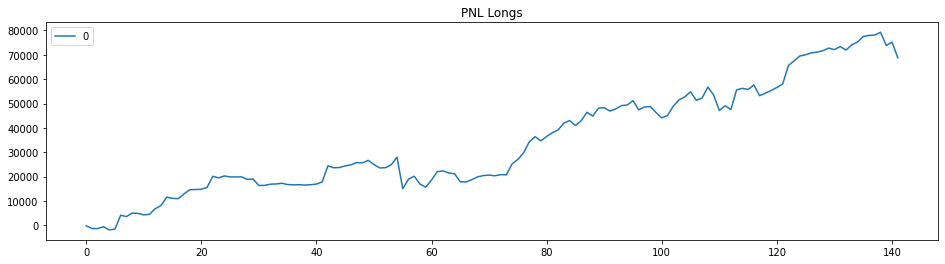

In [75]:
# Displaying cumsum profit PNL graph for longs

longs.cumsum().plot(figsize = (16,4), title="PNL Longs")


<AxesSubplot:title={'center':'PNL Shorts'}>

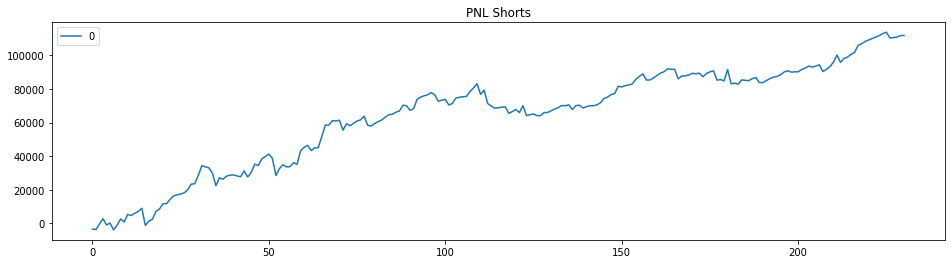

In [76]:
# Displaying cumsum profit PNL graph for short
shorts.cumsum().plot(figsize = (16,4), title="PNL Shorts")

'Coin 2 - 5m Trading Results'

'Account size $100000 --> $280632.74'

'------------------------------------'

'GOA 180.63%.'

'PNL $180632.74.'

'Avg trade $484.27.'

'Total trade count 373.'

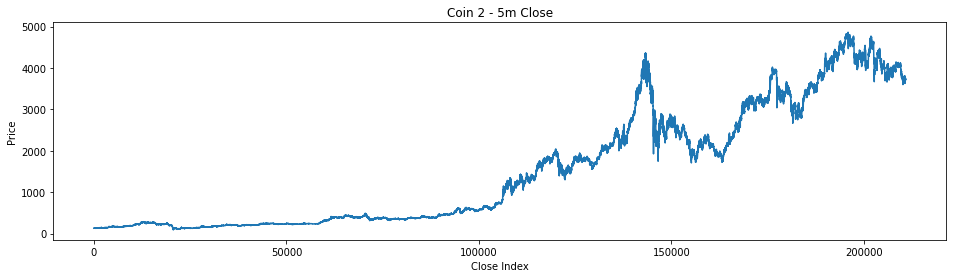

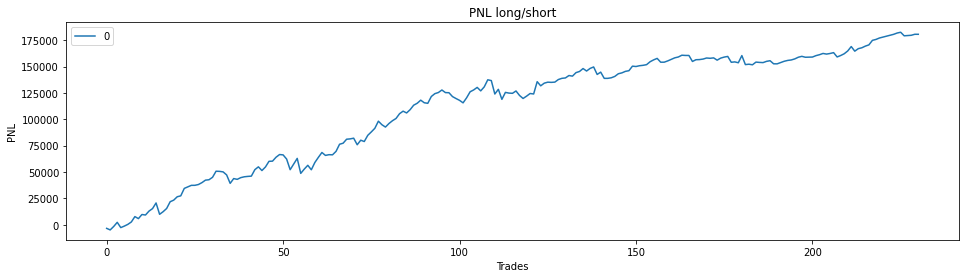

In [77]:
# Plotting closes of trading period and a plot of the PNL to compare

coin_2.plot(y = "close", use_index = True, figsize = (16,4), xlabel = "Close Index", ylabel = "Price", label = "Coin 2", 
            title="Coin 2 - 5m Close")
    
total_profit.cumsum().plot(use_index = True, figsize = (16,4), xlabel = "Trades", ylabel = "PNL", label = "PNL", 
            title="PNL long/short")

# Trading data

display("Coin 2 - 5m Trading Results")
display(f"Account size ${USD} --> ${round(USD + float((shorts.sum() + longs.sum())),2)}")

display("------------------------------------")

display((f"GOA {round(float((((((shorts.sum() + longs.sum()).sum() + USD) - USD)/USD))*100),2)}%."))
display(f"PNL ${round(float(shorts.sum() + longs.sum()),2)}.")
display(f"Avg trade ${round(float((shorts.sum() + longs.sum())/(len(shorts) + len(longs))),2)}.")
display(f"Total trade count {len(shorts) + len(longs)}.")